In [58]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm_notebook as tqdm
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets
import warnings

warnings.filterwarnings("ignore")

In [59]:
tf.keras.backend.set_floatx("float64")

class Dist(tf.keras.Model):
    def __init__(self):
        super().__init__()
        
        self.dense1 = tf.keras.layers.Dense(64)
        self.dense2 = tf.keras.layers.Dense(64)
        self.out = tf.keras.layers.Dense(1)
           
    def call(self, x):
        x = tf.nn.tanh(self.dense1(x))
        x = tf.nn.tanh(self.dense2(x))
        
        return tf.math.exp(self.out(x))

    
class DNModel(tf.keras.Model):
    def __init__(self):
        super().__init__()
        
        self.dist1 = Dist()
        self.dist2 = Dist()
        
    def call(self, x1, x2):
        x = tf.concat((x1, x2), axis=1)
        psi1 = self.dist1(x1)
        psi2 = self.dist2(x)
        
        return psi1*psi2
    
    
    
@tf.function
def loss(model, x1, x2):
    
    with tf.GradientTape() as g:
        g.watch(x1)
        with tf.GradientTape() as gg:
            gg.watch(x1)
            
            psi = model.call(x1, x2)

        d_psi = gg.gradient(psi, x1)
    d2_psi1 = g.gradient(d_psi, x1)
    
    with tf.GradientTape() as g:
        g.watch(x2)
        with tf.GradientTape() as gg:
            gg.watch(x2)
            
            psi = model.call(x1, x2)

        d_psi = gg.gradient(psi, x2)
    d2_psi2 = g.gradient(d_psi, x2)
    
    lap = d2_psi1 + d2_psi2
    
    psi = model.call(x1, x2)
    E_L = -0.5/psi*lap + 0.5*(x1**2 + x2**2) + 1/tf.math.sqrt((x1-x2)**2 + 0.1**2)
    
    E_L = tf.stop_gradient(E_L)
    E = tf.math.reduce_mean(E_L)
    
    
    psi_detach = tf.stop_gradient(psi)
    return E, 2*(tf.math.reduce_mean(psi/psi_detach*E_L) - tf.math.reduce_mean(psi/psi_detach)*E)


@tf.function
def grad(model, x1, x2):
    with tf.GradientTape() as tape:
        E, loss_value = loss(model, x1, x2)

    return E, tape.gradient(loss_value, model.trainable_variables)



def sample1(model, N, n):
    total = 0
    x_old = tf.random.uniform((N,1), minval=-2, maxval=2, dtype=tf.dtypes.float64)
    psi_old = model.dist1(x_old).numpy()
    
    for i in range(n):
        x_new = x_old + tf.random.uniform((N,1), minval=-1, maxval=1, dtype=tf.dtypes.float64)
        psi_new = model.dist1(x_new).numpy()
      
    
        U = np.random.uniform(0, 1, (N,1))
        mask = ((psi_new/psi_old)**2 > U) #vectorized acceptance criterion
        x_old = x_old.numpy()
        x_new = x_new.numpy()
        
        x_old[mask]   = x_new[mask]  #move walkers
        psi_old[mask] = psi_new[mask]
        x_old = tf.convert_to_tensor(x_old, dtype=tf.dtypes.float64)
        total += np.sum(mask)
    
    return x_old, total

def sample2(model, N, n, x1):
    total = 0
    x_old = tf.random.uniform((N,1), minval=-2, maxval=2, dtype=tf.dtypes.float64)
    x = tf.concat((x1, x_old), axis=1)
    
    psi_old = model.dist2(x).numpy()
    
    for i in range(n):
        x_new = x_old + tf.random.uniform((N,1), minval=-1, maxval=1, dtype=tf.dtypes.float64)
        x = tf.concat((x1, x_new), axis=1)
        psi_new = model.dist2(x).numpy()
      
    
        U = np.random.uniform(0, 1, (N,1))
        mask = ((psi_new/psi_old)**2 > U) #vectorized acceptance criterion
        x_old = x_old.numpy()
        x_new = x_new.numpy()
        
        x_old[mask]   = x_new[mask]  #move walkers
        psi_old[mask] = psi_new[mask]
        x_old = tf.convert_to_tensor(x_old, dtype=tf.dtypes.float64)
        total += np.sum(mask)
    
    return x_old, total

In [60]:
N = 5000
num_epochs = 3000
energy = []

tf.random.set_seed(42)
np.random.seed(42)
model = DNModel()
optimizer = tf.keras.optimizers.Adam(epsilon=1e-08)

In [61]:
for epoch in tqdm(range(num_epochs)):
    x1 = sample1(model, N, 20)[0]
    x2 = sample2(model, N, 20, x1)[0]

    E, gradients = grad(model, x1, x2)
    energy.append(E)
    
    optimizer.apply_gradients(zip(gradients, model.trainable_variables))
    
    if epoch%100 == 0: 
        print(f"epoch: {epoch}, Energy: {E}")

epoch: 0, Energy: 8.745126500248292
epoch: 100, Energy: 2.8229947756163836
epoch: 200, Energy: 2.896165946768019
epoch: 300, Energy: 2.6754756475887564
epoch: 400, Energy: 2.6435418807756155
epoch: 500, Energy: 2.649172347499435
epoch: 600, Energy: 2.632317252670135
epoch: 700, Energy: 2.6461834999767175
epoch: 800, Energy: 2.652268258652577
epoch: 900, Energy: 2.640556827228512
epoch: 1000, Energy: 2.628369581565873
epoch: 1100, Energy: 2.6441138044926613
epoch: 1200, Energy: 2.635244866261887
epoch: 1300, Energy: 2.649423072697345
epoch: 1400, Energy: 2.6619345571192063
epoch: 1500, Energy: 2.6190574639982933
epoch: 1600, Energy: 2.5735836708872806
epoch: 1700, Energy: 2.5646812816369504
epoch: 1800, Energy: 2.5615088230375562
epoch: 1900, Energy: 2.546503210774132
epoch: 2000, Energy: 2.5639429720981624
epoch: 2100, Energy: 2.5416784990615082
epoch: 2200, Energy: 2.5551872904127033
epoch: 2300, Energy: 2.557747142133351
epoch: 2400, Energy: 2.557748019030031
epoch: 2500, Energy: 2.5

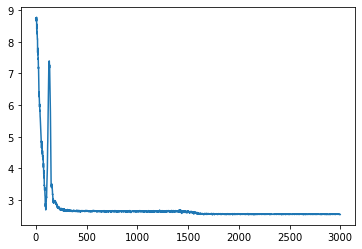

In [62]:
plt.plot(energy)
plt.show()

In [63]:
def f(x):
    x_lin = np.linspace(-4, 4, 1000)
    dx = x_lin[1] - x_lin[0]
    tf_x_lin = tf.convert_to_tensor(x_lin.reshape(-1,1), dtype=tf.dtypes.float64)

    x1 = tf.convert_to_tensor(x*np.ones((1000,1)), dtype=tf.dtypes.float64)

    x_con = tf.concat((x1, tf_x_lin), axis=1)

    psi1 = model.dist1(tf_x_lin).numpy()[:, 0]
    psi2 = model.dist2(x_con).numpy()[:, 0]
    psi3 = np.exp(-0.5*x_lin**2)

    plt.plot(x_lin, 1/dx*psi1**2/np.sum(psi1**2))
    plt.plot(x_lin, 1/dx*psi2**2/np.sum(psi2**2))
    plt.plot(x_lin, 1/dx*psi3**2/np.sum(psi3**2), "--")
    
    plt.plot(x, 0.01, "bo")
    plt.ylim(0, 0.8)
    plt.show()

interact(f, x=(-4.0, 4., 0.1))

interactive(children=(FloatSlider(value=0.0, description='x', max=4.0, min=-4.0), Output()), _dom_classes=('wi…

<function __main__.f(x)>